In [ ]:
##  Quiz
* TrainValidationSplit를 이용하여 영화리뷰 긍/부정 예측  
  Estimator pipeline을 테스트(trainRatio = 0.8)
* ParamGridBuilder를 사용하여 Word2Vec의 파라미터 vectorSize를 5,10,20,40으로 바꾸어 정확도를 측정하여 출력
* 정확도는 BinaryClassificationEvaluator를 사용할 것

# Import Required Libraries

In [2]:
import findspark
findspark.init()

# create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("my app").master("local").getOrCreate()

# get context from the session
sc = spark.sparkContext

In [3]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [4]:
from pyspark import keyword_only
from pyspark.sql.types import ArrayType, StringType

# Spark Session Configuration

In [3]:
conf = SparkConf().setAppName("10 Week") \
                  .setMaster("local[4]") \
                  .set("spark.driver.memory", "16g") \
                  .set("spark.executor.memory", "16g")

spark = SparkSession.builder \
                    .config(conf=conf) \
                    .getOrCreate()

sc = spark.sparkContext

# Data Load

In [4]:
data = spark.read.csv("imdb-review-sentiment.csv", inferSchema=True, header=True, escape='"')
data.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|I grew up (b. 196...|    0|
|When I put this m...|    0|
|Why do people who...|    0|
|Even though I hav...|    0|
|Im a die hard Dad...|    1|
+--------------------+-----+
only showing top 5 rows



In [5]:
data.count()

40000

In [6]:
data.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



# Spark ML

In [7]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import Tokenizer, HashingTF, Word2Vec, VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [8]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

In [9]:
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

In [10]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [11]:
class RemoveStopWords(Transformer, HasInputCol, HasOutputCol):
    
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, stopWords=None):
        super(RemoveStopWords, self).__init__()
        
        self.stopWords = Param(self, "stopWords", "stopWords")
        self._setDefault(stopWords=set())
        
        kwargs = self._input_kwargs
        self._set(**kwargs)
        
        if stopWords:
            self._setStopwords(stopWords)
        
    def _setStopwords(self, value):
        self._paramMap[self.stopWords] = value
        
    def _getStopwords(self):
        return self.getOrDefault(self.stopWords)
        
    def _transform(self, dataset):
        inCol = self.getInputCol()
        outCol = self.getOutputCol()
        stopwords = self._getStopwords()
        
        udf = F.udf(lambda tokens: [token for token in tokens if token not in stopwords], returnType=ArrayType(StringType()))
        return dataset.withColumn(outCol, udf(dataset[inCol]))

In [12]:
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
remove_sw = RemoveStopWords(inputCol="tokens", outputCol="tokensWithoutSW", stopWords=stopwords)
tf = HashingTF(inputCol="tokensWithoutSW", outputCol="tf")

In [13]:
preprocessing = Pipeline(stages=[
    tokenizer,
    remove_sw,
    tf,
])

In [14]:
preprocessed_data = preprocessing.fit(data).transform(data)
train_set, test_set = preprocessed_data.randomSplit([0.6, 0.4], seed=7)

In [15]:
w2v = Word2Vec(vectorSize=10, maxIter=10, minCount=1, inputCol="tokensWithoutSW", outputCol="w2v")
vector_assembler = VectorAssembler(inputCols=["tf", "w2v"], outputCol="features")
clf = LinearSVC()

In [16]:
estimator = Pipeline(stages=[
    w2v,
    vector_assembler,
    clf
])

In [17]:
param_grid = ParamGridBuilder().addGrid(w2v.vectorSize, [5, 10, 20, 40]).build()

In [18]:
evaluator = BinaryClassificationEvaluator()

In [29]:
split = TrainValidationSplit(estimator=estimator, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8, collectSubModels=True)

In [30]:
model = split.fit(train_set)

In [31]:
model.subModels

[PipelineModel_0d60d81f3ed6,
 PipelineModel_46b8aae180f1,
 PipelineModel_882a62e706aa,
 PipelineModel_75c9508db088]

In [50]:
acc = []

for i, subModel in enumerate(model.subModels):
    print(i)
    test_pred = subModel.transform(test_set)
    N = test_pred.count()
    
    acc.append(
        test_pred.filter(test_pred["prediction"] == test_pred["label"]).count() / N
    )

0
1
2
3


In [51]:
for _acc, param in zip(acc, [5, 10, 20, 40]):
    print(f"Accuracy when vector size is {param}: {_acc}")

Accuracy when vector size is 5: 0.8696876760342993
Accuracy when vector size is 10: 0.8694373161419541
Accuracy when vector size is 20: 0.8711272454152845
Accuracy when vector size is 40: 0.8698754459535583


In [52]:
import matplotlib.pyplot as plt

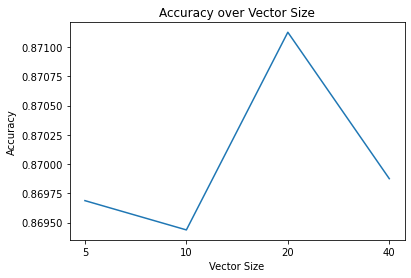

In [56]:
plt.plot(acc)
plt.title("Accuracy over Vector Size")
plt.xticks(ticks=range(4), labels=[5, 10, 20, 40])
plt.xlabel("Vector Size")
plt.ylabel("Accuracy")
plt.show()

In [39]:
test_pred.count()

15977

In [40]:
test_pred.rdd.map(lambda row: float(row["prediction"] == float(row["label"]))).reduce(lambda a, b: a + b)

13918.0